# Imports

In [1]:
!pip install -q shap dask[dataframe]

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import shap

# Load the Data

In [3]:
# Load the California Housing dataset
data = fetch_california_housing(as_frame=True)
df = data.frame

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Prepare the Data

In [4]:
# Define features and target variable
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# List of feature names
feature_names = X.columns.tolist()

In [5]:
# Split the data into training (60%), validation (20%), and testing sets (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

In [6]:
# Print shapes
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (12384, 8)
Validation set shape: (4128, 8)
Test set shape: (4128, 8)


In [7]:
# Add an intercept term to the features for the linear regression model
X_train_lr = X_train.copy()
X_val_lr = X_val.copy()
X_test_lr = X_test.copy()
X_train_lr['Intercept'] = 1
X_val_lr['Intercept'] = 1
X_test_lr['Intercept'] = 1

# Update feature names for linear regression
feature_names_lr = X_train_lr.columns.tolist()

In [8]:
# Compute correlations excluding the intercept term
correlations = X_train_lr.drop(columns=['Intercept']).corrwith(y_train)
print(correlations)

MedInc        0.689202
HouseAge      0.106235
AveRooms      0.179062
AveBedrms    -0.061139
Population   -0.033653
AveOccup     -0.030561
Latitude     -0.144455
Longitude    -0.044328
dtype: float64


# Train the Model

## Dummy Model

In [9]:
# Create and train a dummy regressor on the training set
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

DummyRegressor()

## Linear Regression Model

In [10]:
# Function to train a constrained linear regression model
def train_constrained_linear_model(X_train, y_train, monotonicity):
    """
    Train a linear regression model with monotonic constraints using constrained optimization.

    Parameters:
    X_train (DataFrame): Training features with intercept term.
    y_train (Series): Training target variable.
    monotonicity (list): List of monotonicity constraints for each feature:
                         1 for non-negative coefficients,
                        -1 for non-positive coefficients,
                         0 for no constraint.

    Returns:
    coef (ndarray): Optimized coefficients.
    """
    # Define the loss function (sum of squared errors)
    def loss_function(coef, X, y):
        predictions = X @ coef
        residuals = y - predictions
        return np.sum(residuals ** 2)

    # Initial guess for coefficients
    initial_coef = np.zeros(X_train.shape[1])

    # Set up constraints based on monotonicity
    constraints = []
    for i, m in enumerate(monotonicity):
        if m == 1:
            # Coefficient must be >= 0
            constraints.append({'type': 'ineq', 'fun': lambda c, i=i: c[i]})
        elif m == -1:
            # Coefficient must be <= 0
            constraints.append({'type': 'ineq', 'fun': lambda c, i=i: -c[i]})
        # No constraint if m == 0

    # Perform constrained optimization
    result = minimize(
        loss_function,
        initial_coef,
        args=(X_train.values, y_train.values),
        method='SLSQP',
        constraints=constraints,
        options={'maxiter': 1000}
    )

    # Check if optimization was successful
    if not result.success:
        print("Optimization failed:", result.message)

    coef = result.x
    return coef

In [11]:
# Define monotonicity constraints for each feature (including intercept)
# MedInc has a constraint of 1 (coefficient >= 0)
# Other features and intercept have no constraint (0)
monotonicity_lr = [1, 0, 0, 0, 0, 0, 0, 0, 0]  # Including intercept

# Train the constrained linear regression model
coef_lr = train_constrained_linear_model(X_train_lr, y_train, monotonicity_lr)

# Convert coefficients to pandas Series for easy handling
coef_series_lr = pd.Series(coef_lr, index=feature_names_lr)

## LightGBM Model

In [12]:
# Define monotonic constraints for LightGBM (excluding intercept)
monotonicity_lgb = [1, 0, 0, 0, 0, 0, 0, 0]  # Excluding intercept

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# Set up LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'monotone_constraints': monotonicity_lgb,
    'verbosity': -1
}

In [13]:
# Set up callbacks
callbacks = [
    early_stopping(stopping_rounds=50, first_metric_only=False, verbose=False),
    log_evaluation(period=0)  # Set period=0 to disable logging if verbose_eval=False
]

# Train the LightGBM model
model_lgb = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=callbacks
)

# Make Predictions

In [14]:
# Make predictions with the dummy model on training, validation, and test sets
y_dummy_train_pred = dummy_model.predict(X_train)
y_dummy_val_pred = dummy_model.predict(X_val)
y_dummy_test_pred = dummy_model.predict(X_test)

In [15]:
# Make predictions on the training, validation, and test sets
y_train_pred_lr = X_train_lr @ coef_series_lr
y_val_pred_lr = X_val_lr @ coef_series_lr
y_test_pred_lr = X_test_lr @ coef_series_lr

In [16]:
# Make predictions with the LightGBM model
y_train_pred_lgb = model_lgb.predict(X_train)
y_val_pred_lgb = model_lgb.predict(X_val)
y_test_pred_lgb = model_lgb.predict(X_test)

# Evaluate the Model

## Utility Functions

In [17]:
# Function to compute out-of-sample R²
def oos_r2_score(y_true, y_pred, y_dummy_pred):
    """Compute out-of-sample R-squared."""
    mse_pred = mean_squared_error(y_true, y_pred)
    mse_dummy = mean_squared_error(y_true, y_dummy_pred)
    oos_r2 = 1 - (mse_pred / mse_dummy)
    return oos_r2

In [18]:
# Function to compute SHAP values for a linear model
def compute_shap_values_linear(coef, X, X_mean):
    """
    Compute SHAP values for a linear model.

    Parameters:
    coef (Series): Coefficients of the linear model (including intercept).
    X (DataFrame): Feature data (including intercept term).
    X_mean (Series): Mean of each feature in the training data.

    Returns:
    shap_values (DataFrame): SHAP values for each feature and instance.
    """
    # SHAP values for linear models: (X - X_mean) * coef
    shap_values = (X - X_mean) * coef
    return shap_values

In [19]:
# Function to compute error contributions
def compute_error_contributions(y_true, y_pred, shap_values):
    """
    Compute error contributions for each feature.

    Parameters:
    y_true (Series): True target values.
    y_pred (Series): Predicted target values.
    shap_values (DataFrame): SHAP values for each feature and instance.

    Returns:
    error_contribution (Series): Mean error contribution for each feature.
    prediction_contribution (Series): Mean absolute SHAP value for each feature.
    """
    # Compute the original absolute error
    abs_error = (y_true - y_pred).abs()

    # Compute predictions without each feature's contribution
    y_pred_wo_feature = pd.DataFrame(index=y_true.index)
    for feature in shap_values.columns:
        y_pred_wo_feature[feature] = y_pred - shap_values[feature]

    # Compute the new absolute error without each feature
    abs_error_wo_feature = pd.DataFrame(index=y_true.index)
    for feature in shap_values.columns:
        abs_error_wo_feature[feature] = (y_true - y_pred_wo_feature[feature]).abs()

    # Compute error contribution for each feature
    error_contribution = (abs_error.values.reshape(-1, 1) - abs_error_wo_feature).mean()
    error_contribution = pd.Series(error_contribution, index=shap_values.columns)
    error_contribution = error_contribution.rename('error_contribution')
    error_contribution = error_contribution.sort_values(ascending=False)

    # Compute prediction contribution (mean absolute SHAP values)
    prediction_contribution = shap_values.abs().mean()
    prediction_contribution = prediction_contribution.rename('prediction_contribution')
    prediction_contribution = prediction_contribution.sort_values(ascending=False)

    return error_contribution, prediction_contribution

In [20]:
# Function to plot contributions
def plot_contributions(contributions, dataset_name):
    """
    Plot the relationship between prediction contributions and error contributions for a dataset.

    Parameters:
    contributions (DataFrame): DataFrame with 'prediction_contribution' and 'error_contribution' columns.
    dataset_name (str): Name of the dataset for the plot title.
    """
    fig, ax = plt.subplots()

    ax.scatter(
        contributions["prediction_contribution"],
        contributions["error_contribution"],
        s=80, color="orange", edgecolors="black"
    )
    ax.hlines(
        y=0,
        xmin=0,
        xmax=contributions["prediction_contribution"].max(),
        ls="--",
        color="black"
    )
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_title(f"{dataset_name} Dataset", fontsize=12)
    ax.set_xlabel("Prediction Contribution", fontsize=12)
    ax.set_ylabel("Error Contribution", fontsize=12)
    plt.show()

In [21]:
# Function to evaluate model performance
def evaluate_model_performance(y_true, y_pred, y_dummy_pred, dataset_name):
    """
    Compute and print the OOS R² and standard R² for a dataset.

    Parameters:
    y_true (Series): True target values.
    y_pred (Series): Predicted target values.
    y_dummy_pred (array): Predictions from the dummy regressor.
    dataset_name (str): Name of the dataset.
    """
    oos_r2 = oos_r2_score(y_true, y_pred, y_dummy_pred)
    standard_r2 = r2_score(y_true, y_pred)
    print(f"Out-of-sample R² on {dataset_name} Set (OOS R²): {oos_r2:.4f}")
    print(f"Standard R² on {dataset_name} Set: {standard_r2:.4f}")
    return oos_r2, standard_r2

## Linear Regression Model

In [22]:
# Evaluate linear regression model performance on validation and test sets
print("Constrained Linear Regression Model Performance:")
oos_r2_val_lr, standard_r2_val_lr = evaluate_model_performance(y_val, y_val_pred_lr, y_dummy_val_pred, "Validation")
oos_r2_test_lr, standard_r2_test_lr = evaluate_model_performance(y_test, y_test_pred_lr, y_dummy_test_pred, "Test")

Constrained Linear Regression Model Performance:
Out-of-sample R² on Validation Set (OOS R²): 0.6143
Standard R² on Validation Set: 0.6142
Out-of-sample R² on Test Set (OOS R²): 0.5713
Standard R² on Test Set: 0.5713


In [23]:
# Compute the mean of each feature in the training data (linear regression)
X_train_mean_lr = X_train_lr.mean()

# Compute SHAP values for the linear regression model on the validation set
shap_values_val_lr = compute_shap_values_linear(coef_series_lr, X_val_lr, X_train_mean_lr)

# Ensure y_val and y_val_pred are pandas Series with correct index
y_val_pred_lr = pd.Series(y_val_pred_lr, index=y_val.index)

In [24]:
# Compute error contributions for the validation set (linear regression)
error_contribution_val_lr, prediction_contribution_val_lr = compute_error_contributions(
    y_val, y_val_pred_lr, shap_values_val_lr
)

# Create DataFrame for contributions (linear regression)
contributions_val_lr = pd.DataFrame({
    'prediction_contribution': prediction_contribution_val_lr,
    'error_contribution': error_contribution_val_lr
})

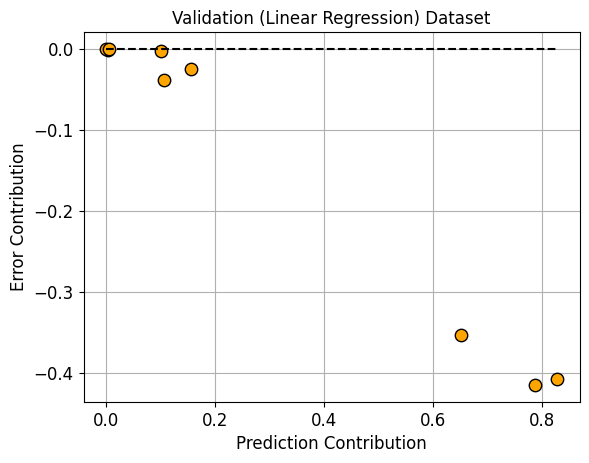

In [25]:
# Visualization for Validation Set (linear regression)
plot_contributions(contributions_val_lr, "Validation (Linear Regression)")

In [26]:
# Display the error contributions (linear regression)
print("Error Contribution for Validation Set (Linear Regression):")
print(error_contribution_val_lr)

# Display the prediction contributions (linear regression)
print("\nPrediction Contribution for Validation Set (Linear Regression):")
print(prediction_contribution_val_lr)

Error Contribution for Validation Set (Linear Regression):
Population    0.000256
Intercept     0.000000
AveOccup     -0.001480
HouseAge     -0.002035
AveRooms     -0.024237
AveBedrms    -0.038428
MedInc       -0.352565
Latitude     -0.407792
Longitude    -0.414561
Name: error_contribution, dtype: float64

Prediction Contribution for Validation Set (Linear Regression):
Latitude      0.827168
Longitude     0.787318
MedInc        0.651195
AveRooms      0.155874
AveBedrms     0.106326
HouseAge      0.100251
Population    0.006059
AveOccup      0.003536
Intercept     0.000000
Name: prediction_contribution, dtype: float64


## LightGBM Model

In [27]:
# Evaluate LightGBM model performance on validation and test sets
print("LightGBM Model Performance:")
oos_r2_val_lgb, standard_r2_val_lgb = evaluate_model_performance(y_val, y_val_pred_lgb, y_dummy_val_pred, "Validation")
oos_r2_test_lgb, standard_r2_test_lgb = evaluate_model_performance(y_test, y_test_pred_lgb, y_dummy_test_pred, "Test")

LightGBM Model Performance:
Out-of-sample R² on Validation Set (OOS R²): 0.8304
Standard R² on Validation Set: 0.8303
Out-of-sample R² on Test Set (OOS R²): 0.8281
Standard R² on Test Set: 0.8281


In [28]:
# Compute SHAP values for the LightGBM model on the validation set
explainer_lgb = shap.TreeExplainer(model_lgb)
shap_values_val_lgb = explainer_lgb.shap_values(X_val)

# Convert SHAP values to DataFrame
shap_values_val_lgb_df = pd.DataFrame(shap_values_val_lgb, columns=X_val.columns, index=X_val.index)

# Ensure y_val and y_val_pred_lgb are pandas Series with correct index
y_val_pred_lgb = pd.Series(y_val_pred_lgb, index=y_val.index)

In [29]:
# Compute error contributions for the validation set (LightGBM)
error_contribution_val_lgb, prediction_contribution_val_lgb = compute_error_contributions(
    y_val, y_val_pred_lgb, shap_values_val_lgb_df
)

# Create DataFrame for contributions (LightGBM)
contributions_val_lgb = pd.DataFrame({
    'prediction_contribution': prediction_contribution_val_lgb,
    'error_contribution': error_contribution_val_lgb
})

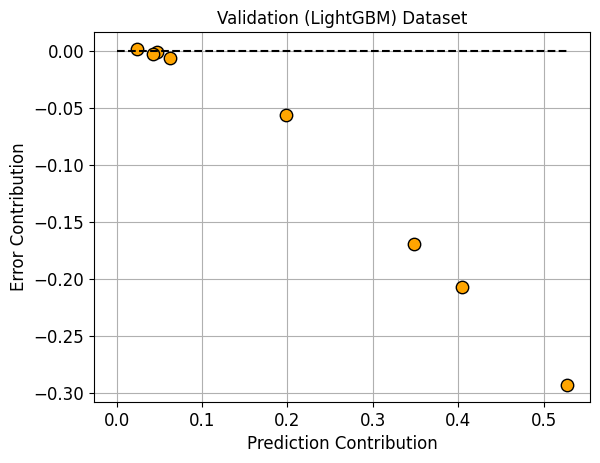

In [30]:
# Visualization for Validation Set (LightGBM)
plot_contributions(contributions_val_lgb, "Validation (LightGBM)")

In [31]:
# Display the error contributions (LightGBM)
print("Error Contribution for Validation Set (LightGBM):")
print(error_contribution_val_lgb)

# Display the prediction contributions (LightGBM)
print("\nPrediction Contribution for Validation Set (LightGBM):")
print(prediction_contribution_val_lgb)

Error Contribution for Validation Set (LightGBM):
Population    0.001704
AveBedrms    -0.000996
AveRooms     -0.002761
HouseAge     -0.006379
AveOccup     -0.056031
Longitude    -0.169720
Latitude     -0.206873
MedInc       -0.293261
Name: error_contribution, dtype: float64

Prediction Contribution for Validation Set (LightGBM):
MedInc        0.527660
Latitude      0.403946
Longitude     0.348142
AveOccup      0.197971
HouseAge      0.062793
AveBedrms     0.047856
AveRooms      0.042542
Population    0.023850
Name: prediction_contribution, dtype: float64


# Model Comparison

In [32]:
# Compare performance of Linear Regression and LightGBM models
performance_df = pd.DataFrame({
    'Model': ['Constrained Linear Regression', 'LightGBM'],
    'Validation OOS R²': [oos_r2_val_lr, oos_r2_val_lgb],
    'Validation R²': [standard_r2_val_lr, standard_r2_val_lgb],
    'Test OOS R²': [oos_r2_test_lr, oos_r2_test_lgb],
    'Test R²': [standard_r2_test_lr, standard_r2_test_lgb]
})

print("Model Performance Comparison:")
print(performance_df)

Model Performance Comparison:
                           Model  Validation OOS R²  Validation R²  \
0  Constrained Linear Regression           0.614269       0.614201   
1                       LightGBM           0.830356       0.830327   

   Test OOS R²   Test R²  
0     0.571341  0.571285  
1     0.828074  0.828052  


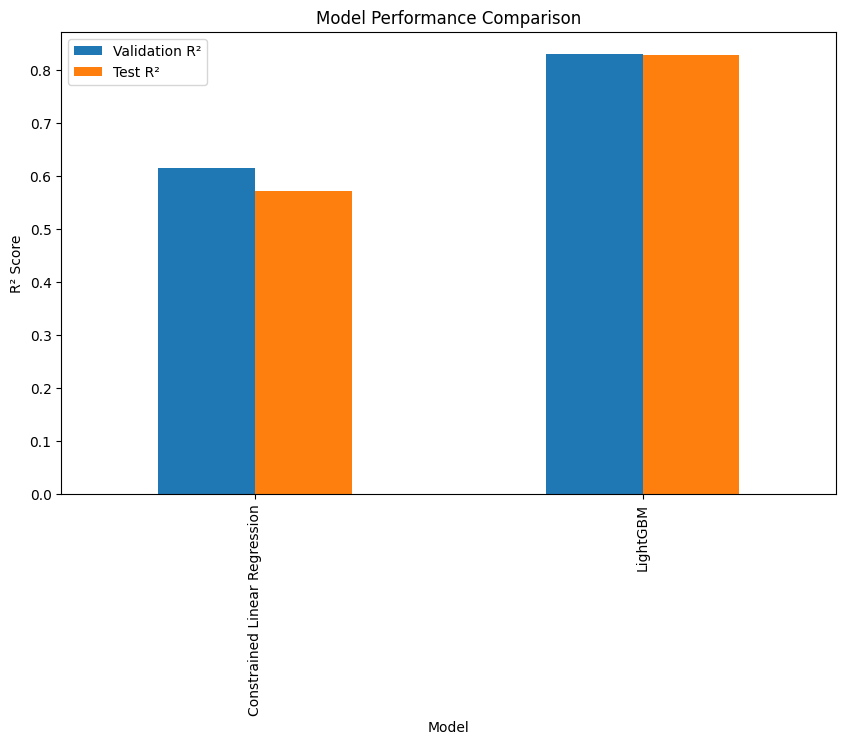

In [33]:
# Plotting the performance comparison
performance_df.set_index('Model')[['Validation R²', 'Test R²']].plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison')
plt.ylabel('R² Score')
plt.show()

# Feature Selection

## Linear Regression Model

In [34]:
# Select features with negative error contributions
features_to_keep_lr = error_contribution_val_lr[error_contribution_val_lr < 0].index.tolist()
print(f"Features to keep based on negative error contribution (Validation Set) for Linear Regression: {features_to_keep_lr}")

Features to keep based on negative error contribution (Validation Set) for Linear Regression: ['AveOccup', 'HouseAge', 'AveRooms', 'AveBedrms', 'MedInc', 'Latitude', 'Longitude']


In [35]:
# Prepare training, validation, and test sets with selected features
X_train_selected_lr = X_train_lr[features_to_keep_lr]
X_val_selected_lr = X_val_lr[features_to_keep_lr]
X_test_selected_lr = X_test_lr[features_to_keep_lr]

# Update monotonicity for selected features
selected_feature_indices_lr = [feature_names_lr.index(f) for f in features_to_keep_lr]
monotonicity_selected_lr = [monotonicity_lr[i] for i in selected_feature_indices_lr]

# Retrain the constrained linear regression model with selected features
coef_selected_lr = train_constrained_linear_model(X_train_selected_lr, y_train, monotonicity_selected_lr)
coef_selected_series_lr = pd.Series(coef_selected_lr, index=features_to_keep_lr)

In [36]:
# Make predictions with the selected model on validation and test sets
y_val_pred_selected_lr = X_val_selected_lr @ coef_selected_series_lr
y_test_pred_selected_lr = X_test_selected_lr @ coef_selected_series_lr

# Evaluate the retrained linear regression model on validation and test sets
print("Linear Regression Model Performance After Feature Selection:")
oos_r2_val_selected_lr, standard_r2_val_selected_lr = evaluate_model_performance(y_val, y_val_pred_selected_lr, y_dummy_val_pred, "Validation")
oos_r2_test_selected_lr, standard_r2_test_selected_lr = evaluate_model_performance(y_test, y_test_pred_selected_lr, y_dummy_test_pred, "Test")

Linear Regression Model Performance After Feature Selection:
Out-of-sample R² on Validation Set (OOS R²): 0.5477
Standard R² on Validation Set: 0.5477
Out-of-sample R² on Test Set (OOS R²): 0.5197
Standard R² on Test Set: 0.5196


## LightGBM Model

In [37]:
# Select features with negative error contributions
features_to_keep_lgb = error_contribution_val_lgb[error_contribution_val_lgb < 0].index.tolist()
print(f"Features to keep based on negative error contribution (Validation Set) for LightGBM: {features_to_keep_lgb}")

Features to keep based on negative error contribution (Validation Set) for LightGBM: ['AveBedrms', 'AveRooms', 'HouseAge', 'AveOccup', 'Longitude', 'Latitude', 'MedInc']


In [38]:
# Prepare training, validation, and test sets with selected features
X_train_selected_lgb = X_train[features_to_keep_lgb]
X_val_selected_lgb = X_val[features_to_keep_lgb]
X_test_selected_lgb = X_test[features_to_keep_lgb]

# Update monotonicity for selected features
selected_feature_indices_lgb = [feature_names.index(f) for f in features_to_keep_lgb]
monotonicity_selected_lgb = [monotonicity_lgb[i] for i in selected_feature_indices_lgb]

# Create LightGBM datasets with selected features
lgb_train_selected = lgb.Dataset(X_train_selected_lgb, label=y_train)
lgb_val_selected = lgb.Dataset(X_val_selected_lgb, label=y_val, reference=lgb_train_selected)

# Update LightGBM parameters with selected monotonicity constraints
params_selected = params.copy()
params_selected['monotone_constraints'] = monotonicity_selected_lgb

# Train the LightGBM model with selected features
model_lgb_selected = lgb.train(
    params_selected,
    lgb_train_selected,
    num_boost_round=1000,
    valid_sets=[lgb_train_selected, lgb_val_selected],
    callbacks=callbacks
)

In [39]:
# Make predictions with the selected LightGBM model
y_val_pred_selected_lgb = model_lgb_selected.predict(X_val_selected_lgb)
y_test_pred_selected_lgb = model_lgb_selected.predict(X_test_selected_lgb)

# Evaluate the retrained LightGBM model on validation and test sets
print("LightGBM Model Performance After Feature Selection:")
oos_r2_val_selected_lgb, standard_r2_val_selected_lgb = evaluate_model_performance(y_val, y_val_pred_selected_lgb, y_dummy_val_pred, "Validation")
oos_r2_test_selected_lgb, standard_r2_test_selected_lgb = evaluate_model_performance(y_test, y_test_pred_selected_lgb, y_dummy_test_pred, "Test")

LightGBM Model Performance After Feature Selection:
Out-of-sample R² on Validation Set (OOS R²): 0.8327
Standard R² on Validation Set: 0.8326
Out-of-sample R² on Test Set (OOS R²): 0.8288
Standard R² on Test Set: 0.8288


## Model Comparison

In [40]:
# Compare performance of all models
performance_df = pd.DataFrame({
    'Model': ['Constrained LR', 'Constrained LR (Selected Features)', 'LightGBM', 'LightGBM (Selected Features)'],
    'Validation OOS R²': [oos_r2_val_lr, oos_r2_val_selected_lr, oos_r2_val_lgb, oos_r2_val_selected_lgb],
    'Validation R²': [standard_r2_val_lr, standard_r2_val_selected_lr, standard_r2_val_lgb, standard_r2_val_selected_lgb],
    'Test OOS R²': [oos_r2_test_lr, oos_r2_test_selected_lr, oos_r2_test_lgb, oos_r2_test_selected_lgb],
    'Test R²': [standard_r2_test_lr, standard_r2_test_selected_lr, standard_r2_test_lgb, standard_r2_test_selected_lgb]
})

print("Model Performance Comparison:")
print(performance_df)

Model Performance Comparison:
                                Model  Validation OOS R²  Validation R²  \
0                      Constrained LR           0.614269       0.614201   
1  Constrained LR (Selected Features)           0.547733       0.547654   
2                            LightGBM           0.830356       0.830327   
3        LightGBM (Selected Features)           0.832679       0.832650   

   Test OOS R²   Test R²  
0     0.571341  0.571285  
1     0.519705  0.519643  
2     0.828074  0.828052  
3     0.828805  0.828783  


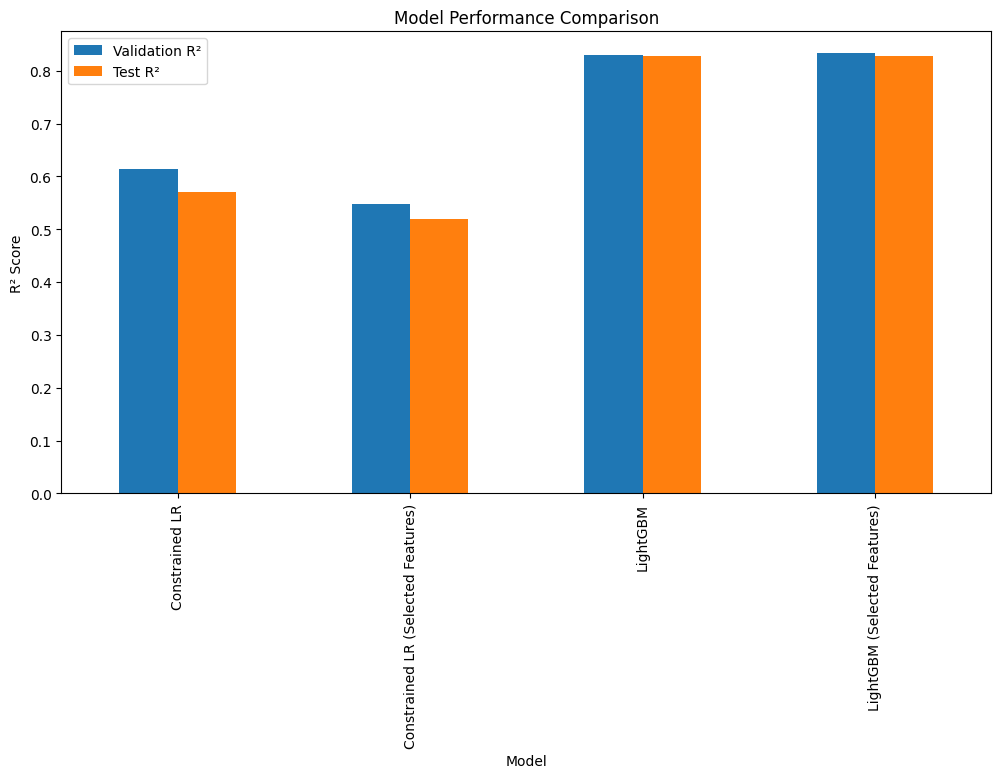

In [41]:
# Plotting the performance comparison
performance_df.set_index('Model')[['Validation R²', 'Test R²']].plot(kind='bar', figsize=(12,6))
plt.title('Model Performance Comparison')
plt.ylabel('R² Score')
plt.show()